In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch
# from utility import get_all_files_paths

In [2]:
TRAIN = False

BETA = 1
BATCH_SIZE = 64
LATENT_SPACE_DIM = 128
LEARNING_RATE = 1e-5

SAVE_ROUND = 20
NUM_EPOCHS = 300

torch.manual_seed(0) # random seed for reproducible results
# 似乎不同设备要单独设置随机种子？

In [14]:
dataset_path="data/spec/fma_small"
# dataset_path="data/spec/GTZAN_646"
model_save_path = "models/Echoes"
csv_save_path = "output/Echoes_output"

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'device: {device}')

device: cuda


In [15]:
class MusicDataset(Dataset):
	def __init__(self, file_paths):
		self.file_paths = file_paths

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, idx):
		file_path = self.file_paths[idx]
		data = np.load(file_path)
	
		if np.isnan(data).any():
			filename = os.path.basename(file_path)
			label = filename.replace(".npy", "").lstrip("0")
			print(f"Warning: NaN value found in {label}")
  
		data = data[np.newaxis, :, :]  # Add a channel dimension
		data = torch.tensor(data, dtype=torch.float32)

		filename = os.path.basename(file_path)
		label = filename.replace(".npy", "").lstrip("0")
		return data, label

file_paths = []
for root, dirs, files in os.walk(dataset_path):
	for file in files:
		file_paths.append(os.path.join(root, file))

# 取出20%的数据作为测试集，10%的数据作为验证集，剩下的作为训练集（理论上每个文件夹有风格区别，应该尽量做到比例均匀），但是（先验的）风格不好分，暂时直接随机划分

m = len(file_paths)
test_size = int(m * 0.15)
valid_size = int(m * 0.15)
train_size = m - test_size - valid_size
# train : valid : test = 70 : 15 : 15

paths = np.array(file_paths)
np.random.shuffle(paths)

train_paths = paths[:train_size]
valid_paths = paths[train_size:train_size + valid_size]
test_paths = paths[train_size + valid_size:]

train_dataset = MusicDataset(train_paths)
valid_dataset = MusicDataset(valid_paths)
test_dataset = MusicDataset(test_paths)

print(f'Training set size:   {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size:       {len(test_dataset)}')

if TRAIN:
	train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
	valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
	test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size:   700
Validation set size: 150
Test set size:       150


In [5]:
if TRAIN:
	loss_fn = torch.nn.MSELoss()
	
	encoder = Encoder(encoded_space_dim=LATENT_SPACE_DIM)
	decoder = Decoder(encoded_space_dim=LATENT_SPACE_DIM)
	params_to_optimize = [
		{'params': encoder.parameters()},
		{'params': decoder.parameters()}
	]

	optim = torch.optim.Adam(params_to_optimize, lr=LEARNING_RATE, weight_decay=1e-05)

	encoder = encoder.to(device)
	decoder = decoder.to(device)
	
	losses = {'train_loss':[],'val_loss':[]}

	for epoch in range(NUM_EPOCHS):
		beta = epoch / NUM_EPOCHS  # Increase beta over time
		# beta = BETA
		train_loss =train_epoch(encoder, decoder, device, train_loader, loss_fn, optim, beta)
		val_loss = test_epoch(encoder, decoder, device, valid_loader, loss_fn, beta)
	
		print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, NUM_EPOCHS,train_loss,val_loss))

		# track losses
		losses['train_loss'].append(train_loss)
		losses['val_loss'].append(val_loss)

		# save model
		if (epoch + 1) % SAVE_ROUND == 0: 
			torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
			torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	test_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn, beta)


 EPOCH 1/300 	 train loss 1.1309947967529297 	 val loss 0.620205819606781

 EPOCH 2/300 	 train loss 39.369937896728516 	 val loss 2.3722283840179443

 EPOCH 3/300 	 train loss 3.618297815322876 	 val loss 3.4563722610473633

 EPOCH 4/300 	 train loss 3.6558279991149902 	 val loss 3.964174270629883

 EPOCH 5/300 	 train loss 3.1909897327423096 	 val loss 4.0122480392456055

 EPOCH 6/300 	 train loss 2.6271309852600098 	 val loss 3.7750473022460938

 EPOCH 7/300 	 train loss 2.1774580478668213 	 val loss 3.518038272857666

 EPOCH 8/300 	 train loss 1.8233164548873901 	 val loss 3.187678575515747

 EPOCH 9/300 	 train loss 1.5779190063476562 	 val loss 3.077625036239624

 EPOCH 10/300 	 train loss 1.394639015197754 	 val loss 2.8639488220214844

 EPOCH 11/300 	 train loss 1.254313349723816 	 val loss 2.7912023067474365

 EPOCH 12/300 	 train loss 1.1503113508224487 	 val loss 2.650928020477295

 EPOCH 13/300 	 train loss 1.0796090364456177 	 val loss 2.5655677318573

 EPOCH 14/300 	 tra

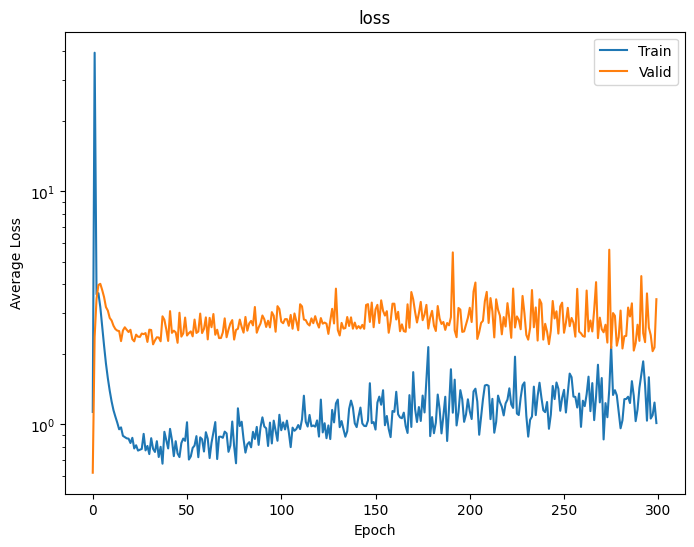

In [6]:
plt.figure(figsize=(8,6))
plt.semilogy(losses['train_loss'], label='Train')
plt.semilogy(losses['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [9]:
test_loss

np.float32(3.4321818)

In [7]:
encoder_path = f"{model_save_path}/encoder.pth"
decoder_path = f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

In [16]:
if not TRAIN:
	encoder_path = f"{model_save_path}/encoder_280.pth"
	encoder = load_encoder(encoder_path, LATENT_SPACE_DIM)
	encoder = encoder.to(device)

encoded_samples = []
for sample in tqdm(test_dataset):
	data = sample[0].unsqueeze(0).to(device)
	label = sample[1]
	encoder.eval()
	with torch.no_grad():
		mu, log_var = encoder(data)

	encoded_data = mu + torch.exp(0.5 * log_var) * torch.randn_like(mu)
	encoded_data = encoded_data.flatten().cpu().numpy()
	encoded_sample = {f"enc. v {i}": enc for i, enc in enumerate(encoded_data)}
	encoded_sample['label'] = label
	encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/fma_small_encoded.csv", index=False)
encoded_samples

100%|██████████| 150/150 [00:00<00:00, 604.24it/s]


,enc. v 0,enc. v 1,enc. v 2,enc. v 3,enc. v 4,enc. v 5,enc. v 6,enc. v 7,enc. v 8,enc. v 9,...,enc. v 119,enc. v 120,enc. v 121,enc. v 122,enc. v 123,enc. v 124,enc. v 125,enc. v 126,enc. v 127,label
0,-0.205862,0.372655,0.101770,-0.991076,-1.395789,1.475381,-1.054161,-0.870036,1.308523,0.733962,...,0.991975,-1.502017,0.624161,-0.441731,-0.429126,-1.445024,1.760490,0.601984,0.294601,jazz.00058
1,0.796363,-1.227036,1.896052,0.863952,-0.838875,-1.775206,-0.259703,1.151453,-0.817411,-1.785251,...,1.001662,-1.082565,1.439528,-1.869813,0.226808,-0.975893,0.441577,0.630153,0.595502,classical.00089
2,-0.734542,0.041228,-1.798316,0.801540,0.098831,-0.023446,-0.156328,1.010796,-0.504986,-0.379288,...,-0.229130,0.067813,0.488800,1.656374,-0.400161,-0.337044,-2.724228,-0.325717,0.327822,rock.00009
3,-0.801351,0.384949,-0.370069,-0.759700,0.831869,1.771652,-1.250881,0.807708,-0.761770,0.220235,...,-0.383922,-0.727587,-0.573642,0.344104,-1.324134,0.852863,1.616000,0.052997,2.557873,classical.00027
4,0.478884,0.719542,-1.083442,-0.806773,0.083420,-1.035088,0.411870,-1.476397,-1.855246,0.856564,...,0.939022,-0.260236,0.843027,1.436546,-0.054620,-1.403516,0.244170,1.368465,1.110582,classical.00064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.699796,-1.106906,1.025356,-1.648157,0.356325,1.145053,-1.010184,0.080319,0.361319,1.218709,...,-0.175882,-0.323096,0.057200,-0.182324,-0.084445,-0.136110,0.271931,0.607786,-1.495726,jazz.00064
146,0.476558,-1.308147,0.320403,-0.369365,-1.315604,1.998836,1.539357,0.770494,0.259797,-0.263021,...,0.039501,1.056122,0.140991,1.831943,-0.496628,0.426105,-1.172289,0.439827,0.286299,reggae.00075
147,-1.608627,-0.896700,2.340569,0.158828,-1.554492,0.539863,0.783361,-0.603687,-1.189562,-0.079504,...,0.372673,0.895081,0.222614,0.131969,1.167903,-0.824960,-0.306807,-0.712270,1.319350,hiphop.00015
148,1.066436,-1.729825,0.754505,0.951269,0.103259,-0.635357,0.280953,0.344625,0.938081,-2.540573,...,1.185386,-0.123047,-1.356839,0.133558,0.041936,0.553075,0.230993,-0.351118,-1.063561,hiphop.00080
